In [27]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Подключаемся к базе (создается в памяти, можно сохранить в файл)
con = duckdb.connect(database=":memory:", read_only=False)

# Загружаем CSV-файлы
con.execute("CREATE TABLE orders AS SELECT * FROM read_csv_auto('Sales Data/orders.csv');")
con.execute("CREATE TABLE order_details AS SELECT * FROM read_csv_auto('Sales Data/order_details.csv');")
con.execute("CREATE TABLE pizzas AS SELECT * FROM read_csv_auto('Sales Data/pizzas.csv');")
con.execute("CREATE TABLE pizza_types AS SELECT * FROM read_csv_auto('Sales Data/pizza_types.csv');")
queries = con.execute("SELECT EXTRACT(HOUR FROM time) FROM orders LIMIT 5;").fetchall()
print(f"Total Orders: {queries[0]}")
# Пример запроса: общее количество заказов
##result = con.execute("SELECT COUNT(DISTINCT order_id) AS total_orders FROM orders;").fetchall()
#print(f"Total Orders: {result[0][0]}")




Total Orders: (11,)


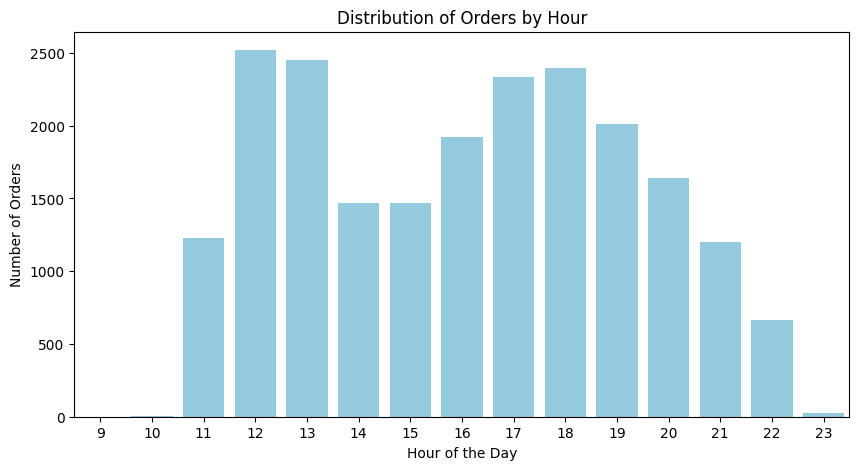

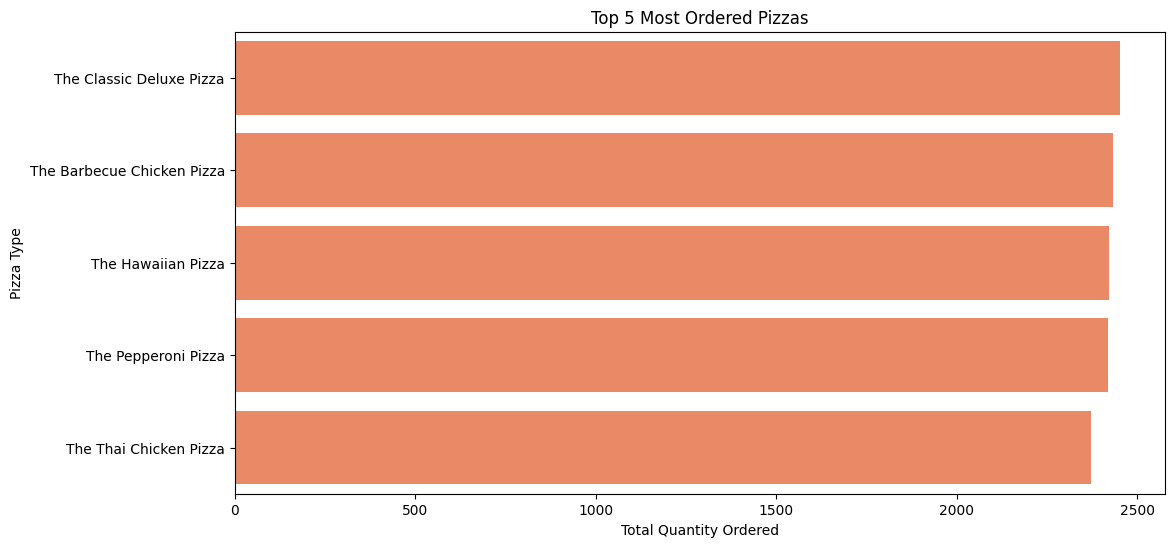

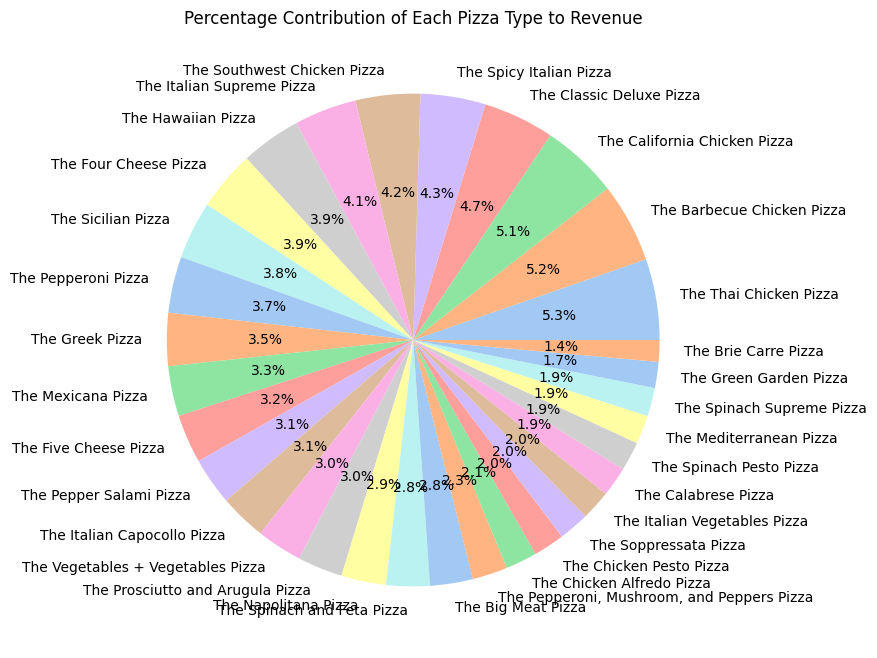

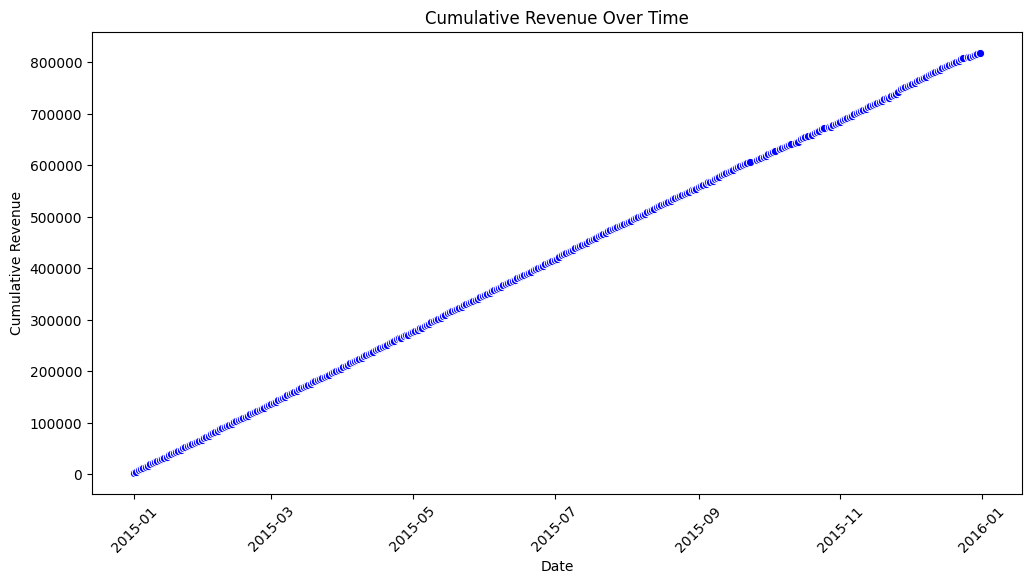

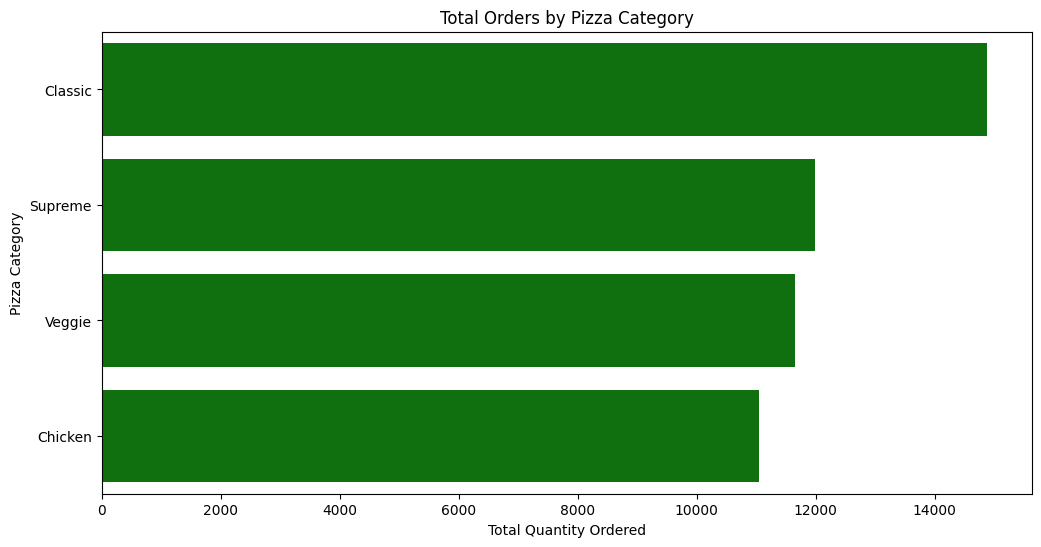

Total Revenue: [(817860.049999993,)]
Highest Priced Pizza: [('the_greek_xxl', 35.95)]
Most Common Pizza Size: [('S', 32)]
-- 1. Retrieve the total number of orders placed.: [(21350,)]
-- 2. Calculate the total revenue generated from pizza sales.: [(817860.049999993,)]
-- 3. Identify the highest-priced pizza.: [('the_greek_xxl', 35.95)]
-- 4. Identify the most common pizza size ordered.: [('S', 32)]
-- 5. List the top 5 most ordered pizza types along with their quantities.: [('The Classic Deluxe Pizza', 2453), ('The Barbecue Chicken Pizza', 2432), ('The Hawaiian Pizza', 2422), ('The Pepperoni Pizza', 2418), ('The Thai Chicken Pizza', 2371)]
-- 6. Join the necessary tables to find the total quantity of each pizza category ordered.: [('Classic', 14888), ('Supreme', 11987), ('Veggie', 11649), ('Chicken', 11050)]
-- 7. Determine the distribution of orders by hour of the day.: [(9, 1), (10, 8), (11, 1231), (12, 2520), (13, 2455), (14, 1472), (15, 1468), (16, 1920), (17, 2336), (18, 2399), (1

In [29]:
# Выполним несколько других запросов
queries = {
    "Total Revenue": "SELECT SUM(od.quantity * p.price) AS total_revenue FROM order_details od JOIN pizzas p ON od.pizza_id = p.pizza_id;",
    "Highest Priced Pizza": "SELECT pizza_id, price FROM pizzas ORDER BY price DESC LIMIT 1;",
    "Most Common Pizza Size": "SELECT size, COUNT(*) AS count FROM pizzas GROUP BY size ORDER BY count DESC LIMIT 1;",
    "-- 1. Retrieve the total number of orders placed.": "SELECT COUNT(DISTINCT order_id) AS total_orders FROM orders;",
    "-- 2. Calculate the total revenue generated from pizza sales.":"SELECT SUM(od.quantity * p.price) AS total_revenue FROM order_details od JOIN pizzas p ON od.pizza_id = p.pizza_id;",
    "-- 3. Identify the highest-priced pizza.":"SELECT pizza_id, price FROM pizzas ORDER BY price DESC LIMIT 1;",
    "-- 4. Identify the most common pizza size ordered.":"SELECT size, COUNT(*) AS count FROM pizzas GROUP BY size ORDER BY count DESC LIMIT 1;",
    "-- 5. List the top 5 most ordered pizza types along with their quantities.":"SELECT pt.name, SUM(od.quantity) AS total_quantity FROM order_details od JOIN pizzas p ON od.pizza_id = p.pizza_id JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id GROUP BY pt.name ORDER BY total_quantity DESC LIMIT 5;",
    "-- 6. Join the necessary tables to find the total quantity of each pizza category ordered.":"SELECT pt.category, SUM(od.quantity) AS total_quantity FROM order_details od JOIN pizzas p ON od.pizza_id = p.pizza_id  JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id GROUP BY pt.category  ORDER BY total_quantity DESC;",
    "-- 7. Determine the distribution of orders by hour of the day.": "SELECT EXTRACT(HOUR FROM time) AS order_hour, COUNT(*) AS order_count FROM orders GROUP BY order_hour ORDER BY order_hour;",    
    "-- 8. Join relevant tables to find the category-wise distribution of pizzas.": "SELECT pt.category, COUNT(DISTINCT p.pizza_id) AS pizza_count FROM pizzas p JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id GROUP BY pt.category ORDER BY pizza_count DESC; ",
    "-- 9. Group the orders by date and calculate the average number of pizzas ordered per day.": "SELECT date, AVG(quantity) AS avg_pizzas_per_day FROM order_details od JOIN orders o ON od.order_id = o.order_id GROUP BY date ORDER BY date;",
    "-- 10. Determine the top 3 most ordered pizza types based on revenue.":"SELECT pt.name, SUM(od.quantity * p.price) AS total_revenue FROM order_details od JOIN pizzas p ON od.pizza_id = p.pizza_id JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id GROUP BY pt.name ORDER BY total_revenue DESC LIMIT 3;",
    "-- 11. Calculate the percentage contribution of each pizza type to total revenue.": "WITH revenue AS (    SELECT pt.name, SUM(od.quantity * p.price) AS pizza_revenue  FROM order_details od      JOIN pizzas p ON od.pizza_id = p.pizza_id     JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id     GROUP BY pt.name ) SELECT name, pizza_revenue,        pizza_revenue * 100.0 / (SELECT SUM(pizza_revenue) FROM revenue) AS percentage FROM revenue ORDER BY pizza_revenue DESC;",
    "-- 12. Analyze the cumulative revenue generated over time.": "SELECT date, SUM(od.quantity * p.price) OVER (ORDER BY date) AS cumulative_revenue FROM order_details od JOIN orders o ON od.order_id = o.order_id JOIN pizzas p ON od.pizza_id = p.pizza_id ORDER BY date;",
    "-- 13. Determine the top 3 most ordered pizza types based on revenue for each pizza category.": "WITH category_revenue AS (    SELECT pt.category, pt.name, SUM(od.quantity * p.price) AS total_revenue,            RANK() OVER (PARTITION BY pt.category ORDER BY SUM(od.quantity * p.price) DESC) AS rank     FROM order_details od     JOIN pizzas p ON od.pizza_id = p.pizza_id     JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id     GROUP BY pt.category, pt.name ) SELECT category, name, total_revenue FROM category_revenue WHERE rank <= 3 ORDER BY category, rank;"
}
query_results = {}
for query_name, query in queries.items():
    df = con.execute(query).fetchdf()
    query_results[query_name] = df

# 1️⃣ Визуализация количества заказов по часам
plt.figure(figsize=(10, 5))
sns.barplot(data=query_results["-- 7. Determine the distribution of orders by hour of the day."], 
            x="order_hour", y="order_count", color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Orders")
plt.title("Distribution of Orders by Hour")
plt.show()

# 2️⃣ Топ-5 самых заказываемых пицц
plt.figure(figsize=(12, 6))
sns.barplot(data=query_results["-- 5. List the top 5 most ordered pizza types along with their quantities."], 
            x="total_quantity", y="name", color="coral")
plt.xlabel("Total Quantity Ordered")
plt.ylabel("Pizza Type")
plt.title("Top 5 Most Ordered Pizzas")
plt.show()

# 3️⃣ Доля выручки от каждой пиццы (Pie Chart)
plt.figure(figsize=(8, 8))
df_pizza_revenue = query_results["-- 11. Calculate the percentage contribution of each pizza type to total revenue."]
plt.pie(df_pizza_revenue["percentage"], labels=df_pizza_revenue["name"], autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Percentage Contribution of Each Pizza Type to Revenue")
plt.show()

# 4️⃣ Анализ накопительной выручки (Line Chart)
plt.figure(figsize=(12, 6))
df_cumulative_revenue = query_results["-- 12. Analyze the cumulative revenue generated over time."]
sns.lineplot(data=df_cumulative_revenue, x="date", y="cumulative_revenue", marker="o", color="blue")
plt.xlabel("Date")
plt.ylabel("Cumulative Revenue")
plt.title("Cumulative Revenue Over Time")
plt.xticks(rotation=45)
plt.show()

# 5️⃣ Количество заказов по категориям пицц
plt.figure(figsize=(12, 6))
sns.barplot(data=query_results["-- 6. Join the necessary tables to find the total quantity of each pizza category ordered."], 
            x="total_quantity", y="category", color="green")
plt.xlabel("Total Quantity Ordered")
plt.ylabel("Pizza Category")
plt.title("Total Orders by Pizza Category")
plt.show()


for query_name, query in queries.items():
    result_query = con.execute(query)
    result = result_query.fetchall()  # Получаем результат



    if result:  # Проверяем, есть ли данные
        df = pd.DataFrame(result, columns=[desc[0] for desc in result_query.description])
        df.to_csv(f"{query_name}.csv", index=False)  # Сохраняем в CSV
        print(f"{query_name}: {result}")
    else:
        print(f"{query_name}: No data returned.")


# Закрываем соединение
con.close()